# Data Visualization Final Project Summer 2018

This project is intended to improve a previous project for the Kaggle Heritage Healthcare Competition: https://www.kaggle.com/c/hhp

The purpose of this project is to demonstrate how using data visualization can assist in creating End-to-end Machine Learning projects.

# Importing needed Libraries

In [1]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
from time import time
from collections import Counter

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Machine Learning
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge, SGDClassifier, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from scipy.stats import randint
from scipy import sparse, stats
from sklearn.preprocessing import StandardScaler, Imputer, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, SVR
from sklearn.utils import check_array
from sklearn_pandas import CategoricalImputer

# Load Data

In [2]:
# Set the directory containing the raw data files
DATA_DIR = os.path.join('data/HHP_release3')

In [3]:
def load_health_data(data_path,filename):
    csv_path = os.path.join(data_path, filename)
    return pd.read_csv(csv_path)

# Preprocessing

The DataFrameSelector class is used in our pipeline to select the attributes.

In [4]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

The ttest function will be used to identify significance between our models.

In [5]:
def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# Load Provided Training Set

Here we are loading and exploring the provided training dataset.

In [6]:
train_X = load_health_data(DATA_DIR,'trainY2_Y3.csv')
train_X.head()

,MemberID,LabCountCount,LabCountMean,LabCountMax,LabCountMin,LabCountSum,PayDelayCount,PayDelayMean,PayDelayMax,PayDelayMin,...,PrimaryConditionGroup_RENAL2,PrimaryConditionGroup_RENAL3,PrimaryConditionGroup_RESPR4,PrimaryConditionGroup_ROAMI,PrimaryConditionGroup_SEIZURE,PrimaryConditionGroup_SEPSIS,PrimaryConditionGroup_SKNAUT,PrimaryConditionGroup_STROKE,PrimaryConditionGroup_TRAUMA,PrimaryConditionGroup_UTI
0,10001471,2,7.000000,9,5,14,12,71.583333,132,17,...,0,0,1,1,0,0,0,0,0,0
1,10002388,2,7.000000,8,6,14,41,58.731707,163,13,...,1,4,0,6,0,0,0,0,0,4
2,10003523,6,4.333333,8,1,26,38,40.526316,163,21,...,0,1,0,0,0,0,0,0,0,0
3,10004817,1,1.000000,1,1,1,15,62.333333,133,24,...,0,0,0,0,0,0,2,0,0,0
4,10008724,1,6.000000,6,6,6,6,68.500000,141,11,...,0,0,0,0,0,0,0,0,0,0


<font color='blue'>
There are 104 columns in this dataset, how can we visualize everything? Using PCA to reduce the dimensions might help us visualize differences.

</font>

In [7]:
cols = train_X.columns

In [8]:
cols

Index(['MemberID', 'LabCountCount', 'LabCountMean', 'LabCountMax',
       'LabCountMin', 'LabCountSum', 'PayDelayCount', 'PayDelayMean',
       'PayDelayMax', 'PayDelayMin',
       ...
       'PrimaryConditionGroup_RENAL2', 'PrimaryConditionGroup_RENAL3',
       'PrimaryConditionGroup_RESPR4', 'PrimaryConditionGroup_ROAMI',
       'PrimaryConditionGroup_SEIZURE', 'PrimaryConditionGroup_SEPSIS',
       'PrimaryConditionGroup_SKNAUT', 'PrimaryConditionGroup_STROKE',
       'PrimaryConditionGroup_TRAUMA', 'PrimaryConditionGroup_UTI'],
      dtype='object', length=104)

In [9]:
features = cols[:17].union(cols[17+1:])

In [10]:
only_features = train_X[features]

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # set the number of components to 2
pca_fitted = pca.fit(only_features)
pca_fitted.explained_variance_ratio_

array([9.99999999e-01, 4.97421240e-10])

<font color='blue'>
We can see that almost no variation is captured by our PCA.
</font>

In [12]:
pca = pca_fitted.transform(only_features)
pca[:5]

array([[-3.99455155e+07,  1.30113818e+02],
       [-3.99445985e+07,  1.67904949e+03],
       [-3.99434635e+07,  8.12265479e+02],
       [-3.99421695e+07,  2.05954487e+02],
       [-3.99382625e+07, -3.17081913e+02]])

In [13]:
pca_df = pd.DataFrame(data=pca, columns=['PC1', 'PC2']).assign(days=train_X['DaysInHospital'])
pca_df.head()

,PC1,PC2,days
0,-3.994552e+07,130.113818,0
1,-3.994460e+07,1679.049492,0
2,-3.994346e+07,812.265479,0
3,-3.994217e+07,205.954487,0
4,-3.993826e+07,-317.081913,0


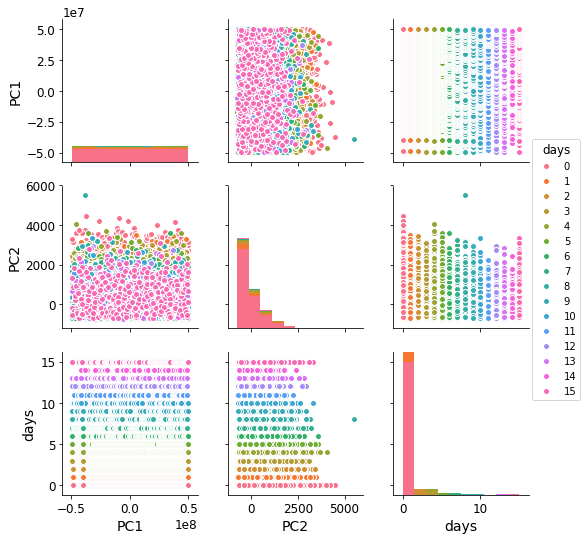

In [15]:
import seaborn as sns
sns.pairplot(pca_df, hue='days')

In [32]:
from sklearn.decomposition import NMF
n_components=5
nmf = NMF(n_components=n_components,random_state=1,alpha=.1, l1_ratio=.5)
nmf_fitted = nmf.fit_transform(only_features)

In [33]:
interest_list = []

In [34]:
n_top = 5
for idx, cluster in enumerate(nmf.components_):
    message = "Cluster #%d: " % idx
    message += " ".join([features[i] for i in cluster.argsort()[:-n_top - 1:-1]])
    interest_list += (features[i] for i in cluster.argsort()[:-n_top - 1:-1])
    print(message)

Cluster #0: ClaimsTruncated LabCountCount LabCountMax LabCountSum LabCountMin
Cluster #1: LabCountCount LabCountMax LabCountMean LengthOfStay.daysCount PayDelaySum
Cluster #2: LabCountMax LengthOfStay.daysMax ClaimsTruncated PayDelaySum LengthOfStay.daysCount
Cluster #3: LengthOfStay.daysMin LabCountMin LabCountSum LabCountCount PlaceSvc_Independent Lab
Cluster #4: LengthOfStay.daysSum MemberID LabCountCount ClaimsTruncated LabCountMin


In [35]:
n_components = 5
nmfKL = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5)
nmfKL_fitted = nmfKL.fit_transform(only_features)

In [36]:
n_top = 5
for idx, cluster in enumerate(nmfKL.components_):
    message = "Cluster #%d: " % idx
    message += " ".join([features[i] for i in cluster.argsort()[:-n_top - 1:-1]])
    interest_list += (features[i] for i in cluster.argsort()[:-n_top - 1:-1])
    print(message)

Cluster #0: ClaimsTruncated LabCountCount LabCountMax LabCountMin LabCountSum
Cluster #1: LabCountCount LabCountMax LengthOfStay.daysMax LabCountMean LengthOfStay.daysCount
Cluster #2: LengthOfStay.daysMax LabCountMax PayDelaySum LengthOfStay.daysCount LabCountMean
Cluster #3: LengthOfStay.daysMin LabCountMin LabCountSum PlaceSvc_Independent Lab PlaceSvc_Home
Cluster #4: LengthOfStay.daysSum MemberID PrimaryConditionGroup_ARTHSPIN PrimaryConditionGroup_CHF LabCountMin


In [45]:
interest_list = pd.Series(interest_list).unique().tolist()
print(interest_list[0:4])

['ClaimsTruncated', 'LabCountCount', 'LabCountMax', 'LabCountSum']


In [46]:
#We know that 'MemberID' should not be influential
interest_list.remove('MemberID')
only_interest = train_X[interest_list[0:4]]

ValueError: list.remove(x): x not in list

In [132]:
pca = PCA(n_components=2) # set the number of components to 2
pca_fitted = pca.fit(train_X[interest_list[0:4]])
pca_fitted.explained_variance_ratio_

array([0.93276803, 0.05601171])

In [134]:
pca_trans = pca_fitted.transform(train_X[interest_list[0:4]])
pca_df = pd.DataFrame(data=pca_trans, columns=['PC1', 'PC2']).assign(days=train_X['DaysInHospital'])
pca_df.head()

,PC1,PC2,days
0,3.856650,-2.225777,0
1,3.646707,-1.276295,0
2,15.834379,1.962252,0
3,-10.581302,2.815234,0
4,-4.662741,-1.037186,0


In [140]:
def pca_var_trans (comp,lst,labl):
    pca = PCA(n_components=comp) # set the number of components
    pca_fitted = pca.fit(lst)
    pca_trans = pca_fitted.transform(lst)
    pca_df = pd.DataFrame(data=pca_trans, columns=['PC1', 'PC2']).assign(label=labl)
    
    return [pca_fitted.explained_variance_ratio_, pca_df]

In [168]:
pca_one = pca_var_trans(2,train_X[interest_list[0:4]],train_X['DaysInHospital'])
pca_two = pca_var_trans(2,train_X[interest_list[5:9]],train_X['DaysInHospital'])
pca_three = pca_var_trans(2,train_X[interest_list[10:14]],train_X['DaysInHospital'])
pca_all = pca_var_trans(2,train_X[interest_list],train_X['DaysInHospital'])

print('Explained Variance Ratio for each NMF cluster')
print ('Cluster 1: {}, Cluster 2: {}, Cluster 3: {}'.format(pca_one[0], pca_two[0], pca_three[0]))
print ('Cluster All: {}'.format(pca_all[0]))

Explained Variance Ratio for each NMF cluster
Cluster 1: [0.93276803 0.05601171], Cluster 2: [9.99902059e-01 7.73457176e-05], Cluster 3: [0.73378035 0.17563901]
Cluster All: [9.99407157e-01 2.49494597e-04]


Text(0.5,0.98,'0 - 4')

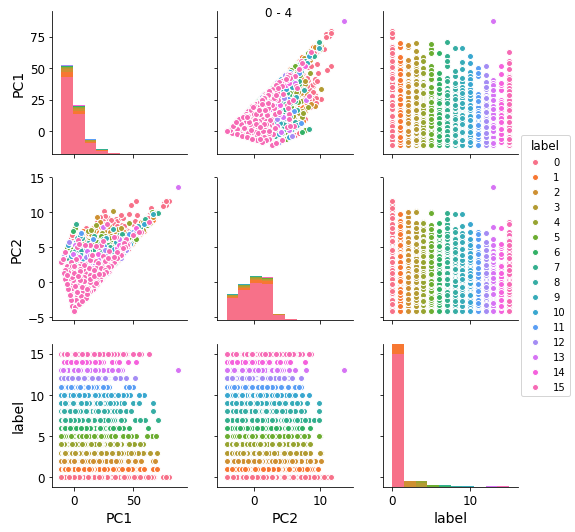

In [165]:
sns.pairplot(pca_one[1], hue='label').fig.suptitle("0 - 4")

Text(0.5,0.98,'5 - 9')

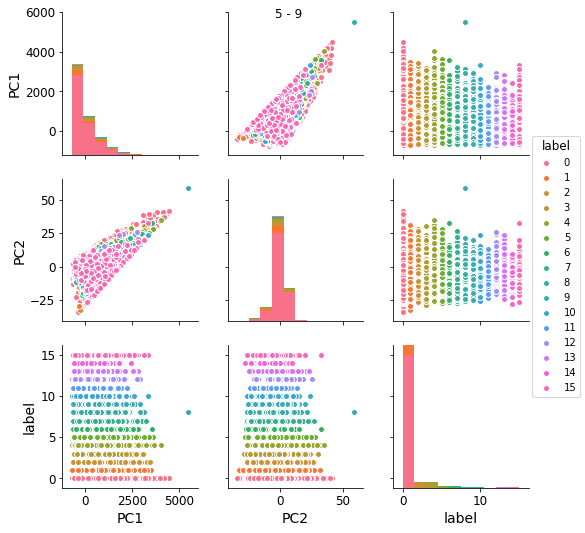

In [166]:
sns.pairplot(pca_two[1], hue='label').fig.suptitle("5 - 9")

Text(0.5,0.98,'10 - 14')

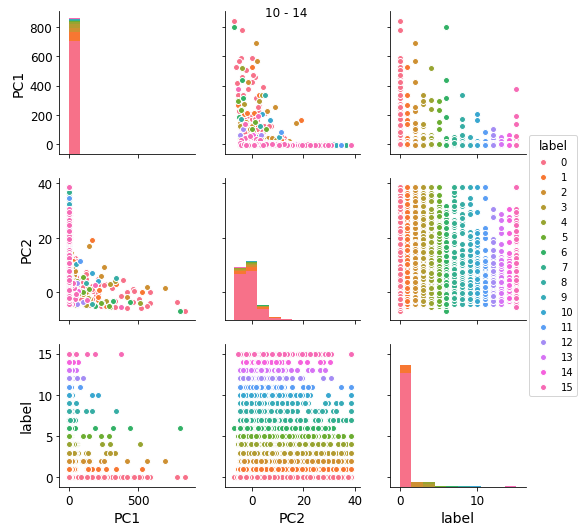

In [167]:
sns.pairplot(pca_three[1], hue='label').fig.suptitle("10 - 14")

Text(0.5,0.98,'Cluster All')

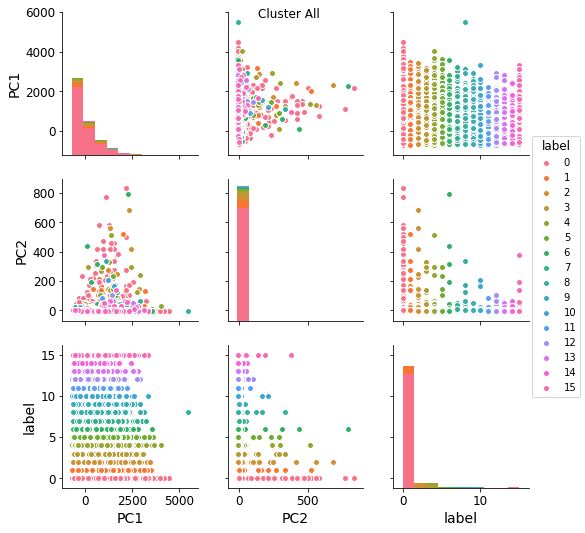

In [169]:
sns.pairplot(pca_all[1], hue='label').fig.suptitle("Cluster All")

In [66]:
import datashader as ds
from datashader import transfer_functions as tf
import holoviews as hv
from holoviews.operation import decimate
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
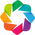

:DynamicMap   []
   :Overlay
      .NdOverlay.A_0 :NdOverlay   [Element]
         :Points   [x,y]
      .RGB.I         :RGB   [PC1,PC2]   (R,G,B,A)

In [123]:
kdims=['PC1','PC2']
num_ks=16
hv.extension('bokeh','matplotlib')


gaussians = {i: hv.Points(pca_df, kdims) for i in range(num_ks)}


gaussspread = dynspread(datashade(hv.NdOverlay(gaussians, kdim='days'), aggregator=ds.count_cat('days')))

from datashader.colors import Sets1to3 # default datashade() and shade() color cycle
color_key = list(enumerate(Sets1to3[0:num_ks]))
color_points = hv.NdOverlay({k: hv.Points([0,0], label=str(k)).options(color=v) for k, v in color_key})

color_points * gaussspread

In [ ]:
sns.swarmplot(x='PC1', y='PC2', data=pca_all[1])

In [172]:
train_X_labels = train_X['DaysInHospital'].copy()
#train_X = train_X.drop(['DaysInHospital'], axis=1) 
# drop labels for training set

Check for any missing values:

In [118]:
sample_incomplete_rows = train_X[train_X.isnull().any(axis=1)].head()
sample_incomplete_rows

,MemberID,LabCountCount,LabCountMean,LabCountMax,LabCountMin,LabCountSum,PayDelayCount,PayDelayMean,PayDelayMax,PayDelayMin,...,PrimaryConditionGroup_RENAL2,PrimaryConditionGroup_RENAL3,PrimaryConditionGroup_RESPR4,PrimaryConditionGroup_ROAMI,PrimaryConditionGroup_SEIZURE,PrimaryConditionGroup_SEPSIS,PrimaryConditionGroup_SKNAUT,PrimaryConditionGroup_STROKE,PrimaryConditionGroup_TRAUMA,PrimaryConditionGroup_UTI


In [119]:
train_X['DaysInHospital'].value_counts(dropna=False).sort_index() 

0     87134
1      6629
2      3508
3      2374
4      1534
5       895
6       547
7       401
8       281
9       226
10      173
11      124
12      117
13      100
14       53
15      399
Name: DaysInHospital, dtype: int64

Text(0.5,0,'Days in Hospital')

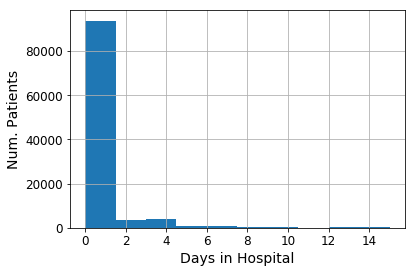

In [111]:
plot = train_X['DaysInHospital'].hist()
plot.set_ylabel('Num. Patients')
plot.set_xlabel('Days in Hospital')

No missing values in the data, that's good!

In [120]:
train_X['LabCountCount'].value_counts(dropna =False).sort_index() 

1     46580
2     25232
3     14054
4      8125
5      4162
6      2317
7      1188
8       728
9       534
10      545
11      596
12      434
Name: LabCountCount, dtype: int64

Text(0,0.5,'Num. Patients')

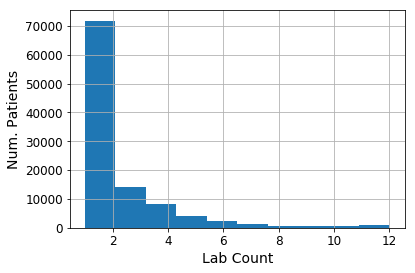

In [110]:
plot = train_X['LabCountCount'].hist()
plot.set_xlabel('Lab Count')
plot.set_ylabel('Num. Patients')

In [121]:
train_X['PayDelayCount'].value_counts(dropna=False).sort_index()

1      763
2     3059
3     5646
4     6238
5     6406
6     6271
7     5835
8     5225
9     5032
10    4561
11    4174
12    3769
13    3379
14    3192
15    2884
16    2654
17    2499
18    2172
19    2010
20    1835
21    1733
22    1613
23    1484
24    1338
25    1351
26    1217
27    1136
28    1012
29     992
30     987
31     945
32     896
33     859
34     884
35     811
36     791
37     793
38     719
39     685
40     692
41     606
42     489
43    4858
Name: PayDelayCount, dtype: int64

Text(0,0.5,'Num. Patients')

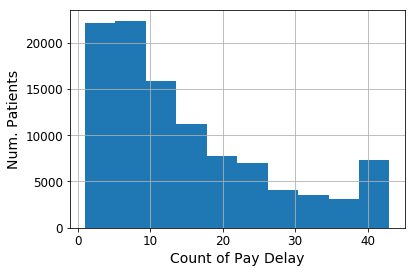

In [113]:
plot = train_X['PayDelayCount'].hist()
plot.set_xlabel('Count of Pay Delay')
plot.set_ylabel('Num. Patients')

In [122]:
train_X['LengthOfStay.daysCount'].value_counts(dropna=False).sort_index()

1      763
2     3059
3     5646
4     6238
5     6406
6     6271
7     5835
8     5225
9     5032
10    4561
11    4174
12    3769
13    3379
14    3192
15    2884
16    2654
17    2499
18    2172
19    2010
20    1835
21    1733
22    1613
23    1484
24    1338
25    1351
26    1217
27    1136
28    1012
29     992
30     987
31     945
32     896
33     859
34     884
35     811
36     791
37     793
38     719
39     685
40     692
41     606
42     489
43    4858
Name: LengthOfStay.daysCount, dtype: int64

Text(0,0.5,'Num. Patients')

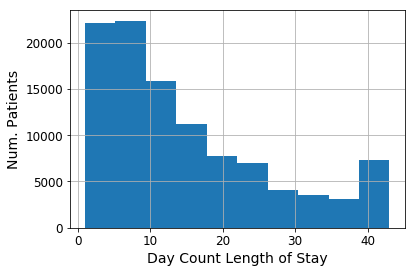

In [114]:
plot = train_X['LengthOfStay.daysCount'].hist()
plot.set_xlabel('Day Count Length of Stay')
plot.set_ylabel('Num. Patients')

Text(0,0.5,'Num. Patients')

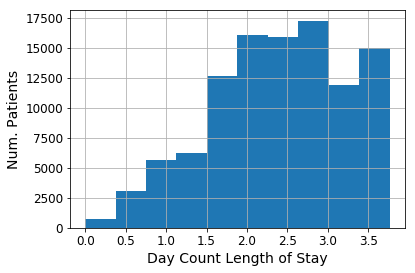

In [125]:
plot = np.log(train_X['LengthOfStay.daysCount']).hist()
plot.set_xlabel('Day Count Length of Stay')
plot.set_ylabel('Num. Patients')

Text(0,0.5,'Num. Patients')

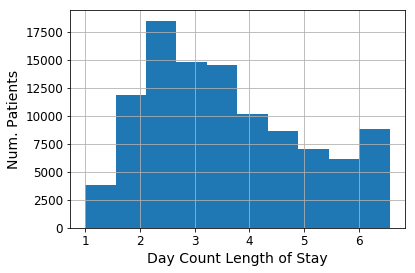

In [124]:
plot = np.sqrt(train_X['LengthOfStay.daysCount']).hist()
plot.set_xlabel('Day Count Length of Stay')
plot.set_ylabel('Num. Patients')

Text(0,0.5,'Num. Patients')

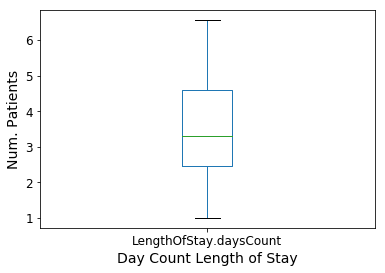

In [130]:
plot = np.sqrt(train_X['LengthOfStay.daysCount']).to_frame().boxplot(grid=False)
plot.set_xlabel('Day Count Length of Stay')
plot.set_ylabel('Num. Patients')

In [123]:
train_X['ClaimsTruncated'].value_counts(dropna=False).sort_index()

0    96698
1     7797
Name: ClaimsTruncated, dtype: int64

### EDA

A correlation matrix will show if any linear correlation exist between the label and the other variables. Even if a linear correlation exists, it does not mean that the relationship is meaning full.

Lets first check out the provided training dataset:

In [170]:
corr_matrix = train_X.corr()
corr_matrix["DaysInHospital"].sort_values(ascending=False)

DaysInHospital                         1.000000
PayDelayCount                          0.188604
LengthOfStay.daysCount                 0.188604
ProcedureGroup_EM                      0.175871
ClaimsTruncated                        0.169226
PayDelaySum                            0.160035
Specialty_Internal                     0.143302
LabCountSum                            0.139105
Specialty_Diagnostic Imaging           0.138110
PlaceSvc_Office                        0.133845
ProcedureGroup_RAD                     0.125355
LabCountCount                          0.124395
ProcedureGroup_PL                      0.123854
PlaceSvc_Independent Lab               0.114570
Specialty_Laboratory                   0.114378
PlaceSvc_Inpatient Hospital            0.111679
Specialty_Emergency                    0.110535
ProcedureGroup_MED                     0.095289
PlaceSvc_Urgent Care                   0.094912
ProcedureGroup_SCS                     0.094130
PayDelayMax                            0

In [174]:
train_X_labels = train_X['DaysInHospital'].copy()
train_X = train_X.drop(['DaysInHospital'], axis=1)

In [177]:
logreg = LogisticRegression()
rfe = RFE(logreg, 5)
rfe = rfe.fit(train_X[interest_list], train_X_labels)
selectedFeature = [cols[x] for x,z in enumerate(rfe.ranking_) if z==1]
print('Support: {} \nRanking: {} \nSelected Features: {}'.format(
        rfe.support_,rfe.ranking_,selectedFeature))

NameError: name 'i' is not defined

In [433]:
given_final = train_X.loc[:, train_X.columns.intersection([
 'ClaimsTruncated',
 'DaysInHospital',
 'ProcedureGroup_ANES',
 'ProcedureGroup_SMCD',
 'PlaceSvc_Ambulance',
 'PlaceSvc_Independent Lab',
 'Specialty_Anesthesiology',
 'Specialty_Diagnostic Imaging',
 'Specialty_Emergency',
 'Specialty_Laboratory',
 'Specialty_Obstetrics and Gynecology',
 'Specialty_Pathology',
 'Specialty_Pediatrics',
 'Specialty_Rehabilitation',
 'PrimaryConditionGroup_APPCHOL',
 'PrimaryConditionGroup_FXDISLC',
 'PrimaryConditionGroup_GIOBSENT',
  'PrimaryConditionGroup_GYNEC1',
])] 

In [434]:
given_final.head()

,ClaimsTruncated,DaysInHospital,ProcedureGroup_ANES,ProcedureGroup_SMCD,PlaceSvc_Ambulance,PlaceSvc_Independent Lab,Specialty_Anesthesiology,Specialty_Diagnostic Imaging,Specialty_Emergency,Specialty_Laboratory,Specialty_Obstetrics and Gynecology,Specialty_Pathology,Specialty_Pediatrics,Specialty_Rehabilitation,PrimaryConditionGroup_APPCHOL,PrimaryConditionGroup_FXDISLC,PrimaryConditionGroup_GIOBSENT,PrimaryConditionGroup_GYNEC1
0,0,0,0,0,0,4,0,1,0,4,0,0,0,0,0,0,0,0
1,1,0,0,0,0,3,0,7,7,3,0,0,0,0,0,0,0,0
2,1,0,0,0,0,24,0,3,2,24,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,5,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,1,0,2,0,0,0,0,0,0,0,0


## Split into train and test

In [72]:
df_train, df_other = train_test_split(df_final, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_other, test_size=0.5, random_state=42)

In [74]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(103231, 26)
(22121, 26)
(22121, 26)


In [340]:
lab_enc = preprocessing.LabelEncoder()

y_train = lab_enc.fit_transform(df_train['label'])
y_val = lab_enc.fit_transform(df_val['label'])
y_test = lab_enc.fit_transform(df_test['label'])

## Run pipeline to produce random prediction

The max label in our created training set is 2.772589 and the max in the dataset provided is 15. Lets create some random prediction for both to complare our models to. 

In [342]:
rand_pred_train = np.log(np.random.randint(0,15,np.size(y_train)) + 1
rand_train_mse = np.sqrt(mean_squared_error(y_train, rand_pred_train))

rand_pred_test = np.log(np.random.randint(0,15,np.size(y_val)) + 1)
rand_test_mse = np.sqrt(mean_squared_error(y_val, rand_pred_test))

results = pd.DataFrame(columns=["ExpID", "Train MSE", "Test MSE", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])
results.loc[0] = ["Random Prediction", round(rand_train_score, 4), round(rand_test_score, 4), "---", "< 1s", "< 1s", "Numpy Random"]

In [343]:
results

,ExpID,Train MSE,Test MSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Random Prediction,1.9017,1.9025,---,< 1s,< 1s,Numpy Random


## Training Linear Models

In [344]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_train_lr = lr.predict(X_train)
score_train_lr = np.sqrt(mean_squared_error(y_train, pred_train_lr))
pred_test_lr = lr.predict(X_val)
score_test_lr = np.sqrt(mean_squared_error(y_val, pred_test_lr))

Visualize what the model is predicting compared to the real labels:

In [345]:
some_data = X_train[1:6]
some_labels = y_train[1:6]

print("Predictions:", lr.predict(some_data))

Predictions: [0.23089028 0.87307205 0.56283707 0.34170092 0.38428698]


Compare against the actual values:

In [346]:
print("Labels:", list(some_labels))

Labels: [0, 0, 0, 0, 2]


Model variables and coefficients

In [347]:
cat_attr = [e for c in cat_values for e in c]
lr_model = dict(zip(num_attribs + cat_attr, lr.coef_))
lr_model

{'ClaimsTruncated': 0.16935928123889651,
 'AgeI': 0.10602581405905498,
 'min_PayDelay': 0.02313625558964999,
 'max_PayDelay': 0.08743422352347408,
 'avg_PayDelay': -0.06252867992873602,
 'min_LOS': 0.018261609190561953,
 'avg_LOS': -0.1025912504324884,
 'max_LOS': 0.16026840229268038,
 'avg_dsfs': 0.04639462569238757,
 'min_DrugCount': 0.020981735835525057,
 'months_DrugCount': -0.03009258612962725,
 'max_DrugCount': 0.11512339561045665,
 'avg_LabCount': 0.04275758002150633,
 'max_LabCount': 0.01323644882002109,
 'months_LabCount': 0.0032155464925388566,
 'min_LabCount': -0.03847789657126113,
 'Sex_f': 0.0,
 'Sex_male': 0.0}

In [359]:
train_X_predictions = lr.predict(X_train)
lr_mse = mean_squared_error(y_train, train_X_predictions)
lr_rmse = np.sqrt(lr_mse)
lr_rmse

1.5444407587943665

An RMSE above 0.5 is not a good indication of the model fit.

In [363]:
lr_mae = mean_absolute_error(y_train, train_X_predictions)
lr_mae

0.7268823221694715

### Bulk Train Linear Models

In [370]:
#Lasso, LinearRegression, LogisticRegression, Ridge, SGDClassifier
regressors = [
    ('Linear', LinearRegression()),
    ('Lasso', Lasso()),
    ('Ridge', Ridge()),
    ('ElasticNet', ElasticNet()),
    ('SGD', SGDClassifier(max_iter=3, tol=None)),
    ('Logistic', LogisticRegression()),
]

for idx, (name, regressor) in enumerate(regressors, 1):
    regressor.fit(X_train, y_train)
    t0 = time()
    cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=42)
    reg_scores = cross_val_score(regressor, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    reg_score_train = np.sqrt(-1*reg_scores).mean()
    t1 = time()
    pred_test_reg = regressor.predict(X_val)
    score_test_reg = np.sqrt(mean_squared_error(y_val, pred_test_reg))
    t2 = time()

    time_train = round(t1 - t0, 4)
    time_test = round(t2 - t1, 4)

    p_value = ttest(rand_pred_test, pred_test_reg)
    results.loc[idx] = ['Baseline ' + name, round(reg_score_train, 4), round(score_test_reg, 4), round(p_value, 4), time_train, time_test, 'Default parameters']



The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (227.28, 0.00000)
Machine learning pipeline A is better than B
The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (228.04, 0.00000)
Machine learning pipeline A is better than B
The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (227.28, 0.00000)
Machine learning pipeline A is better than B
The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (228.04, 0.00000)
Machine learning pipeline A is better than B
The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (242.83, 0.00000)
Machine learning pipeline A is better than B
The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (243.69, 0.00000)
Machine learning pipeline A is better than B


In [371]:
results

,ExpID,Train MSE,Test MSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Random Prediction,1.9017,1.9025,---,< 1s,< 1s,Numpy Random
1,Baseline Linear,1.5469,1.4917,0,2.5524,0,Default parameters
2,Baseline Lasso,1.5851,1.5342,0,1.8664,0,Default parameters
3,Baseline Ridge,1.5469,1.4917,0,1.4418,0,Default parameters
4,Baseline ElasticNet,1.5851,1.5342,0,1.8444,0.0156,Default parameters
5,Baseline SGD,1.6932,1.5891,0,16.5847,0.007,Default parameters
6,Baseline Logistic,1.6503,1.5962,0,215.562,0.0156,Default parameters
8,DecisionTree,2.3013,2.2947,0,20.2582,0.0156,Default parameters


This is pretty terrible.

## Linear Models for the Given Dataset

## Train a Decision Tree Regressor
Train on the training  data and test on the training data (to verify pipelines are working)

In [364]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [365]:
train_X_predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, train_X_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.23439024608372871

### Error on the TRAINING data
Oh! an RMSE < 0.5 is a good sign, maybe something exciting is coming! Lets compare to the linear models and the random prediction.

In [372]:
regressor = DecisionTreeRegressor(random_state=42)

regressor.fit(X_train, y_train)
t0 = time()
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=42)
reg_scores = cross_val_score(regressor, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
reg_score_train = np.sqrt(-1*reg_scores).mean()
t1 = time()
pred_test_reg = regressor.predict(X_val)
score_test_reg = np.sqrt(mean_squared_error(y_val, pred_test_reg))
t2 = time()

time_train = round(t1 - t0, 4)
time_test = round(t2 - t1, 4)

p_value = ttest(rand_pred_test, pred_test_reg)
results.loc[7] = ['DecisionTree', round(reg_score_train, 4), round(score_test_reg, 4), round(p_value, 4), time_train, time_test, 'random_state=42']



The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (206.15, 0.00000)
Machine learning pipeline A is better than B


In [373]:
results

,ExpID,Train MSE,Test MSE,p-value,Train Time(s),Test Time(s),Experiment description
0,Random Prediction,1.9017,1.9025,---,< 1s,< 1s,Numpy Random
1,Baseline Linear,1.5469,1.4917,0,2.5524,0,Default parameters
2,Baseline Lasso,1.5851,1.5342,0,1.8664,0,Default parameters
3,Baseline Ridge,1.5469,1.4917,0,1.4418,0,Default parameters
4,Baseline ElasticNet,1.5851,1.5342,0,1.8444,0.0156,Default parameters
5,Baseline SGD,1.6932,1.5891,0,16.5847,0.007,Default parameters
6,Baseline Logistic,1.6503,1.5962,0,215.562,0.0156,Default parameters
8,DecisionTree,2.3013,2.2947,0,20.2582,0.0156,Default parameters
7,DecisionTree,2.3013,2.2947,0,18.7933,0.0156,Default parameters


## Objective evaluation via  K-fold crossfold validation

In [374]:
scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [375]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [2.2229349  2.31234559 2.34036345 2.30867837 2.27025803 2.20212301
 2.26568697 2.31469845 2.29108991 2.22962475]
Mean: 2.2757803413629163
Standard deviation: 0.04338205908209473


### Minimize MSE is equivalent to maximizing (-MSE)
Grid search will use cross_val_score based on maximizing a utility performance measure. So we maximize(-MSE) here.

In [377]:
lin_scores = cross_val_score(lr, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [1.57017111 1.51125749 1.61446655 1.5538616  1.57988286 1.49477792
 1.53853761 1.53050832 1.54554827 1.50923342]
Mean: 1.5448245157854423
Standard deviation: 0.034563497088910294


In [379]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [382]:
trainY2_predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, trainY2_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.7381220713513715

In [383]:
forest_scores = cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [1.71388463 1.65803682 1.73515516 1.7002682  1.71365027 1.62683294
 1.65994911 1.66556663 1.6659297  1.63417111]
Mean: 1.6773444578575716
Standard deviation: 0.03446827470443095


In [384]:
scores = cross_val_score(lr, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count    10.000000
mean      1.544825
std       0.036433
min       1.494778
25%       1.516070
50%       1.542043
75%       1.566094
max       1.614467
dtype: float64

In [385]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [386]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

Because the max estimator is our set max of 30 we should probably run again with higher values.

In [387]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [397]:
num_attribs

['ClaimsTruncated',
 'AgeI',
 'min_PayDelay',
 'max_PayDelay',
 'avg_PayDelay',
 'min_LOS',
 'avg_LOS',
 'max_LOS',
 'avg_dsfs',
 'min_DrugCount',
 'months_DrugCount',
 'max_DrugCount',
 'avg_LabCount',
 'max_LabCount',
 'months_LabCount',
 'min_LabCount']

In [416]:
sortedFeatures = sorted(zip(grid_search.best_estimator_.feature_importances_,num_attribs), reverse=False)
sortedFeatures

[(0.004936310825153033, 'min_LOS'),
 (0.00862502353959566, 'max_LOS'),
 (0.012443914967679576, 'avg_LOS'),
 (0.01882606721105323, 'ClaimsTruncated'),
 (0.031161737939850158, 'min_DrugCount'),
 (0.038001144630625636, 'min_LabCount'),
 (0.04775971798408856, 'months_LabCount'),
 (0.050251979043986435, 'max_LabCount'),
 (0.05025505574995035, 'max_DrugCount'),
 (0.06699240750747841, 'AgeI'),
 (0.07017659789415448, 'months_DrugCount'),
 (0.07789501574363221, 'avg_LabCount'),
 (0.0999365281233156, 'max_PayDelay'),
 (0.12152368107045872, 'min_PayDelay'),
 (0.14157657582605598, 'avg_dsfs'),
 (0.15963824194292203, 'avg_PayDelay')]

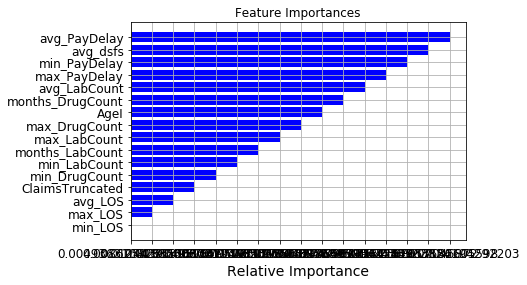

In [417]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(sortedFeatures)[:, 1]
sortedImportances = np.array(sortedFeatures)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

### RandomizedSearchCV

In [406]:
param_distribs = {
        'n_estimators': randint(low=1, high=50),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000003420E438>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000003420E550>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [410]:
rnd_search.best_params_

{'max_features': 5, 'n_estimators': 36}

In [411]:
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=36, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [420]:
sortedFeatures = sorted(zip(rnd_search.best_estimator_.feature_importances_,num_attribs), reverse=False)
sortedFeatures

[(0.004720092930944332, 'min_LOS'),
 (0.007734659751156816, 'max_LOS'),
 (0.012581080997258924, 'avg_LOS'),
 (0.01851072898053474, 'ClaimsTruncated'),
 (0.029261338131732182, 'min_DrugCount'),
 (0.04114246552012518, 'min_LabCount'),
 (0.04650339723420902, 'months_LabCount'),
 (0.04749898368456347, 'max_DrugCount'),
 (0.05099683178425062, 'max_LabCount'),
 (0.05456765579081361, 'AgeI'),
 (0.06541715823097585, 'months_DrugCount'),
 (0.08144073443677094, 'avg_LabCount'),
 (0.0971175310743048, 'max_PayDelay'),
 (0.11678928748149661, 'min_PayDelay'),
 (0.15461720817992478, 'avg_dsfs'),
 (0.17110084579093807, 'avg_PayDelay')]

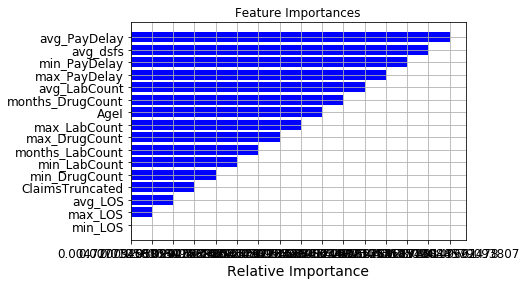

In [421]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(sortedFeatures)[:, 1]
sortedImportances = np.array(sortedFeatures)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
sortedFeatures = sorted(zip(feature_importances), reverse=False)
np.array(sortedFeatures)[:, 0]